In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import re
def load_messy_sentiment_file(filepath):
    with open(filepath, encoding='utf-8') as f:
        lines = f.readlines()
    pattern = re.compile(r'^(.*?)(Positive|Negative|Neutral)$')
    rows = []
    for line in lines:
        m = pattern.search(line.strip())
        if m:
            comment = m.group(1).strip()
            label = m.group(2)
            rows.append([comment, label])
    df = pd.DataFrame(rows, columns=['Comment', 'Sentiment'])
    return df
df = load_messy_sentiment_file('sentiment_analysis_dataset.csv')
print(df.head())
print(df['Sentiment'].value_counts())

                                             Comment Sentiment
0      Achieving million views in days is dangerous,  Positive
1  How many people here want to participate in su...   Neutral
2           Mrbeast is slowly turning into mrjigsaw,  Negative
3     genuinely can't believe how dystopian this is,  Negative
4  "Have of the worlds smartest people compete in...   Neutral
Sentiment
Positive    2987
Neutral     1326
Negative      50
Name: count, dtype: int64


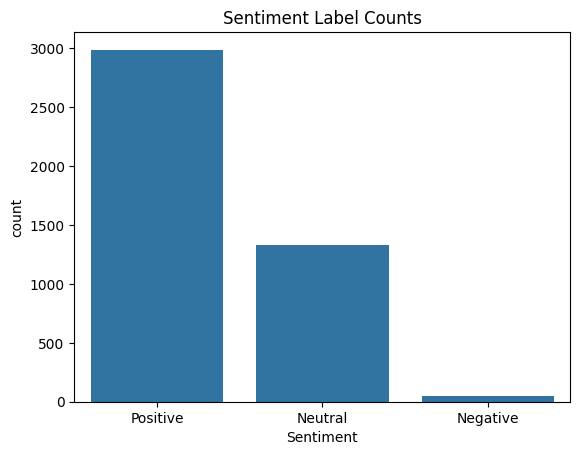

In [6]:
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Label Counts')
plt.show()

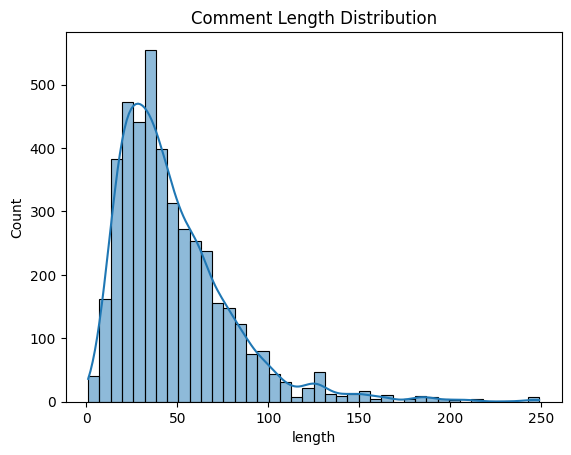

In [7]:
df['length'] = df['Comment'].apply(len)
sns.histplot(df['length'], bins=40, kde=True)
plt.title('Comment Length Distribution')
plt.show()

In [9]:
X = df['Comment']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_vec, y_train)
print("Training accuracy:", model.score(X_train_vec, y_train))

Training accuracy: 0.9581295843520783


In [14]:
y_pred = model.predict(X_test_vec)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.9349220898258478
Classification report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        12
     Neutral       0.95      0.86      0.90       332
    Positive       0.93      0.99      0.96       747

    accuracy                           0.93      1091
   macro avg       0.63      0.61      0.62      1091
weighted avg       0.93      0.93      0.93      1091



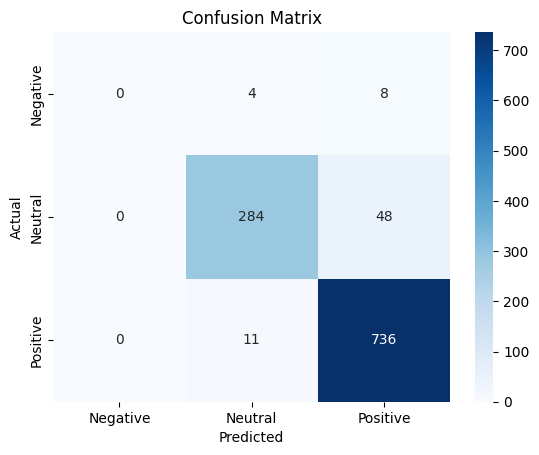

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = model.coef_ 
for idx, label in enumerate(model.classes_):
    top_feat_idx = np.argsort(coefs[idx])[::-1][:10]
    print(f"Top features for {label}: {feature_names[top_feat_idx]}")

Top features for Negative: ['josh' 'dystopian' 'money' 'ragebaiting' 'baiting' 'rage' 'poor' 'stunts'
 'calling' 'easy']
Top features for Neutral: ['vs' 'days' 'airack' 'challenge' 'buy' 'yk' 'said' 'test' 'aloo' 'space']
Top features for Positive: ['congrats' 'happy' 'congratulations' 'amazing' 'coach' 'proud' 'great'
 'best' 'legend' 'thanks']


In [17]:
vect = TfidfVectorizer(stop_words='english', max_features=1500)
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

In [19]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf, y_train)

# SVM (Linear)
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

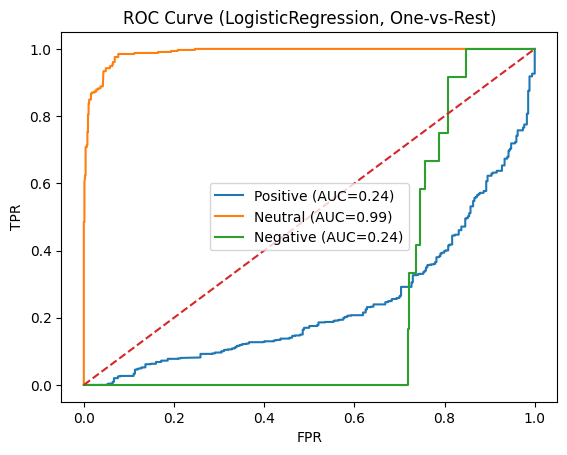

In [21]:
classes = list(df['Sentiment'].unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test_tfidf)

for ix, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:,ix], y_score[:,ix])
    plt.plot(fpr, tpr, label=f"{c} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve (LogisticRegression, One-vs-Rest)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Force plot for class: Negative


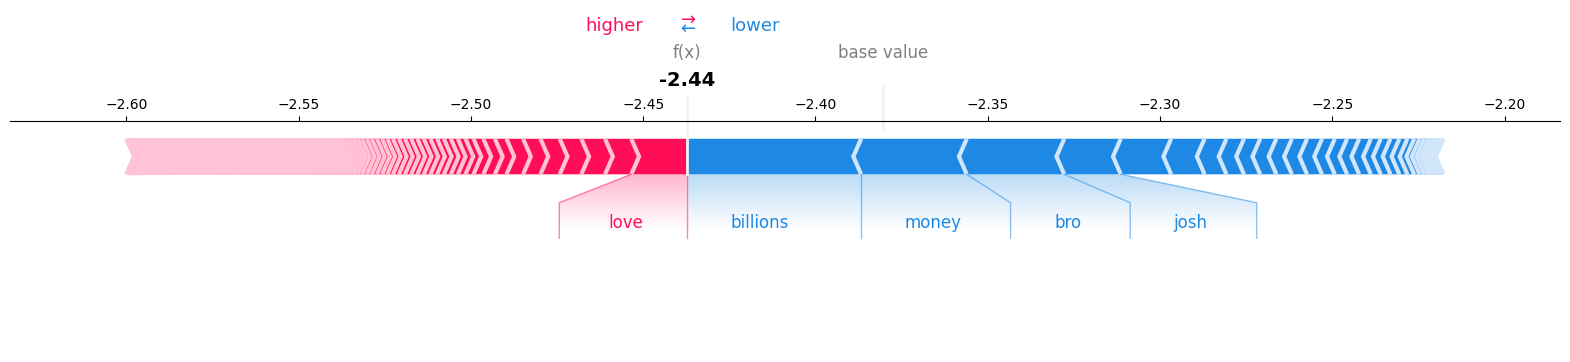

Force plot for class: Neutral


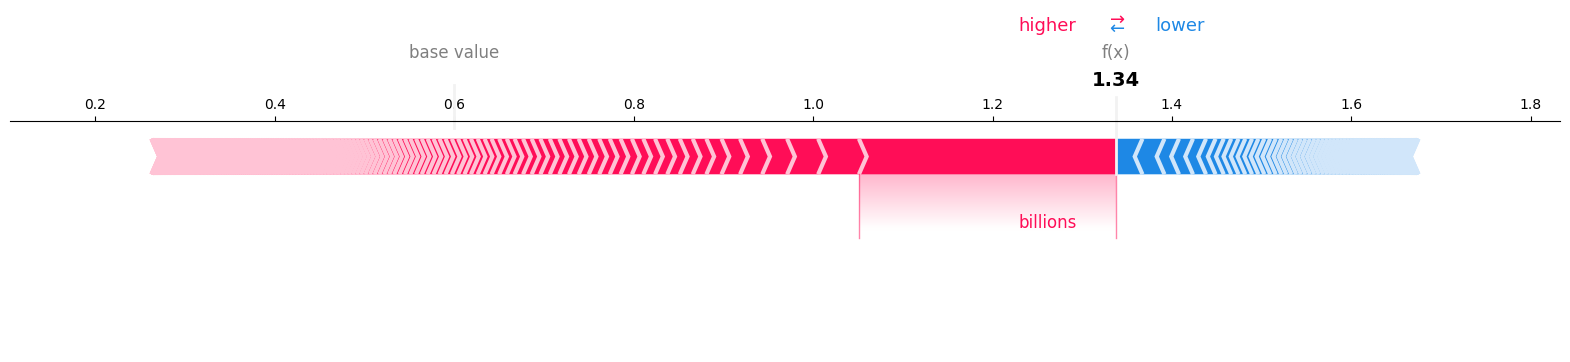

Force plot for class: Positive


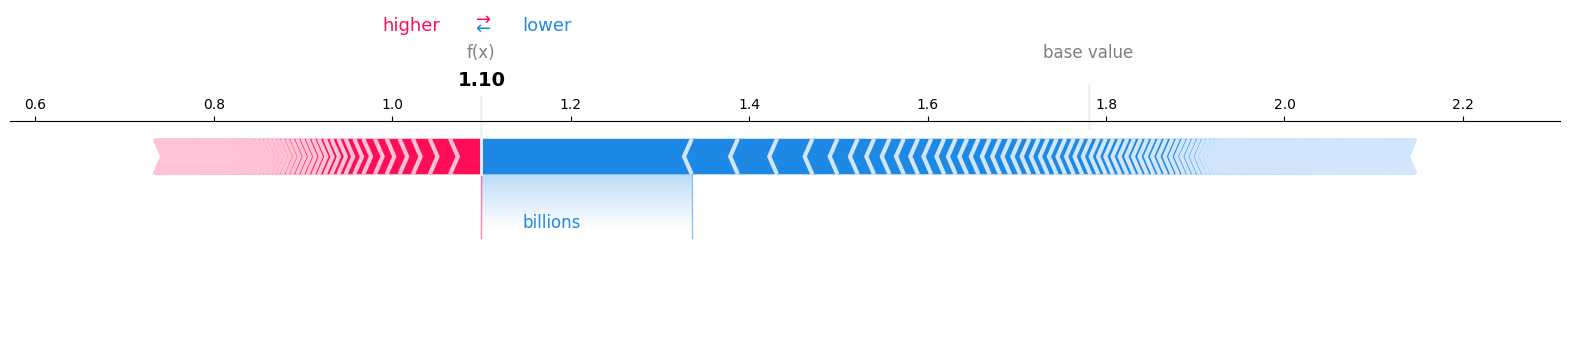

In [24]:
import shap
import numpy as np

explainer = shap.LinearExplainer(model, X_train_tfidf, feature_names=feature_names)
shap_values = explainer(X_test_tfidf)
i = np.random.choice(range(X_test_tfidf.shape[0]))
class_names = model.classes_  

for j, class_label in enumerate(class_names):
    print(f"Force plot for class: {class_label}")
    shap.force_plot(
        explainer.expected_value[j],      
        shap_values.values[i, :, j],      
        feature_names,
        matplotlib=True
    )


In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import plotly.graph_objs as go

classes = list(class_names)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test_tfidf)
roc_traces = []
for ix, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:,ix], y_score[:,ix])
    roc_traces.append(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"{c} (AUC={auc(fpr,tpr):.2f})"))
layout = go.Layout(title='ROC Curves (Logistic Regression)', xaxis=dict(title='FPR'), yaxis=dict(title='TPR'))
roc_fig = go.Figure(roc_traces, layout)
roc_fig.show()
